In [ ]:
!nvidia-smi

Mon Apr  1 09:44:01 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   59C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/drive/MyDrive/projects/insta-reel/sample_vid_data" "/content/sample_vid_data"

In [ ]:
import numpy as np
features = np.load('/content/drive/MyDrive/projects/insta-reel/features.npy')
labels = np.load('/content/drive/MyDrive/projects/insta-reel/labels.npy')

In [ ]:
features.shape,labels.shape

((100, 20, 64, 64, 3), (100,))

In [ ]:
import os
import cv2
import math
import random
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['explicit', 'normal']

In [ ]:
features.shape

(100, 20, 64, 64, 3)

In [ ]:
labels.shape

(100,)

In [ ]:
one_hot_encoded_labels = tf.keras.utils.to_categorical(labels)
one_hot_encoded_labels.shape

(100, 2)

In [ ]:
def create_convlstm_model():
    '''
    This function will construct the required convlstm model.
    Returns:
        model: It is the required constructed convlstm model.
    '''

    # We will use a Sequential model for model construction
    model = tf.keras.Sequential()

    # Define the Model Architecture.
    ########################################################################################################################

    model.add(tf.keras.layers.ConvLSTM2D(filters = 4, kernel_size = (3, 3), activation = 'tanh',data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True, input_shape = (SEQUENCE_LENGTH,
                                                                                      IMAGE_HEIGHT, IMAGE_WIDTH, 3)))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 8, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 14, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dropout(0.2)))

    model.add(tf.keras.layers.ConvLSTM2D(filters = 16, kernel_size = (3, 3), activation = 'tanh', data_format = "channels_last",
                         recurrent_dropout=0.2, return_sequences=True))

    model.add(tf.keras.layers.MaxPooling3D(pool_size=(1, 2, 2), padding='same', data_format='channels_last'))
    #model.add(TimeDistributed(Dropout(0.2)))

    model.add(tf.keras.layers.Flatten())

    model.add(tf.keras.layers.Dense(len(CLASSES_LIST), activation = "softmax"))

    ########################################################################################################################

    # Display the models summary.
    model.summary()

    # Return the constructed convlstm model.
    return model

In [ ]:
convlstm_model = create_convlstm_model()
print("Model Created Successfully!")

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 20, 62, 62, 4)     1024      
                                                                 
 max_pooling3d (MaxPooling3  (None, 20, 31, 31, 4)     0         
 D)                                                              
                                                                 
 time_distributed (TimeDist  (None, 20, 31, 31, 4)     0         
 ributed)                                                        
                                                                 
 conv_lstm2d_1 (ConvLSTM2D)  (None, 20, 29, 29, 8)     3488      
                                                                 
 max_pooling3d_1 (MaxPoolin  (None, 20, 15, 15, 8)     0         
 g3D)                                                            
                                                        

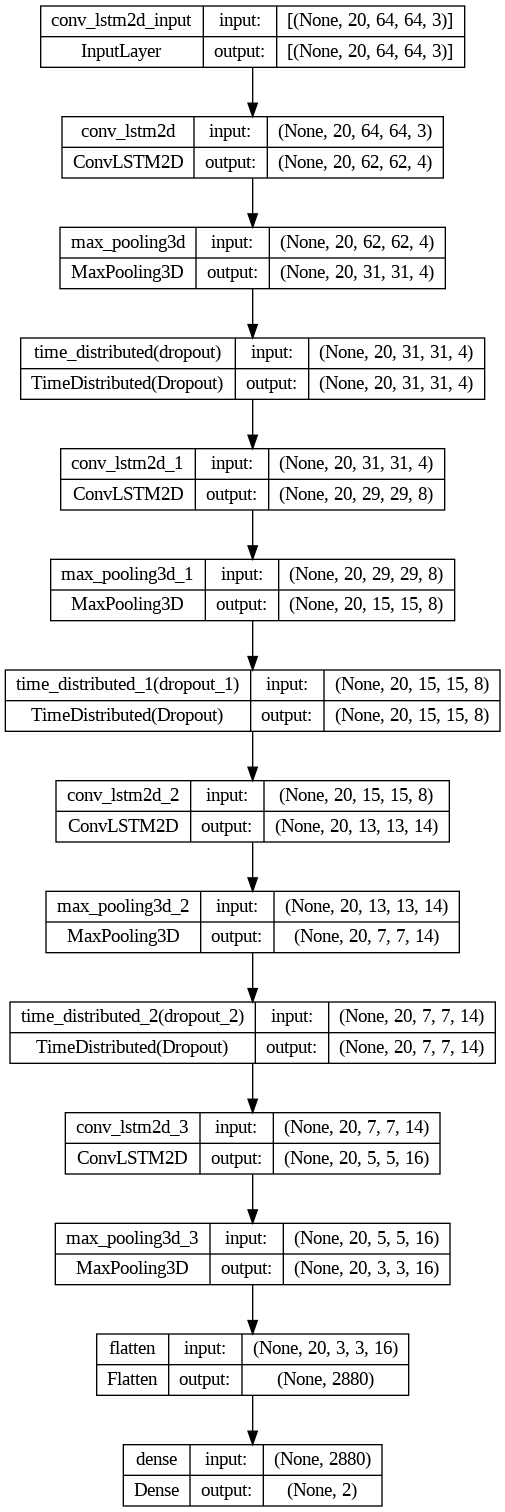

In [ ]:
# Plot the structure of the contructed model.
tf.keras.utils.plot_model(convlstm_model, to_file = 'convlstm_model_structure_plot.png', show_shapes = True, show_layer_names = True)

In [ ]:
# Create an Instance of model_checkpoint_callback
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint('vid_model_checkpoint.keras',
                             monitor='accuracy',
                             save_best_only=True,
                             mode='max',
                             verbose=10)

# Compile the model and specify loss function, optimizer and metrics values to the model
convlstm_model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              metrics = ['accuracy'])

# Start training the model.
convlstm_model_training_history = convlstm_model.fit(x=features, y=one_hot_encoded_labels, epochs=100, batch_size=4, shuffle=True, callbacks=[model_checkpoint_callback])

Epoch 1/100
25/25 [==============================] - ETA: 0s - loss: 0.6927 - accuracy: 0.5300
Epoch 1: accuracy improved from -inf to 0.53000, saving model to vid_model_checkpoint.keras
25/25 [==============================] - 18s 179ms/step - loss: 0.6927 - accuracy: 0.5300
Epoch 2/100
25/25 [==============================] - ETA: 0s - loss: 0.6899 - accuracy: 0.5500
Epoch 2: accuracy improved from 0.53000 to 0.55000, saving model to vid_model_checkpoint.keras
25/25 [==============================] - 5s 212ms/step - loss: 0.6899 - accuracy: 0.5500
Epoch 3/100
25/25 [==============================] - ETA: 0s - loss: 0.6871 - accuracy: 0.5200
Epoch 3: accuracy did not improve from 0.55000
25/25 [==============================] - 5s 184ms/step - loss: 0.6871 - accuracy: 0.5200
Epoch 4/100
25/25 [==============================] - ETA: 0s - loss: 0.6854 - accuracy: 0.5100
Epoch 4: accuracy did not improve from 0.55000
25/25 [==============================] - 8s 321ms/step - loss: 0.6854 -

In [ ]:
!cp "vid_model_checkpoint.keras" "/content/drive/MyDrive/projects/insta-reel/."

In [ ]:
convlstm_model = tf.keras.models.load_model('vid_model_checkpoint.keras')

In [ ]:
model_evaluation_history = convlstm_model.evaluate(features, one_hot_encoded_labels)

3/3 [==============================] - 3s 97ms/step - loss: 0.3567 - accuracy: 0.8421


In [ ]:
# Get the loss and accuracy from model_evaluation_history.
model_evaluation_loss, model_evaluation_accuracy = model_evaluation_history

In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

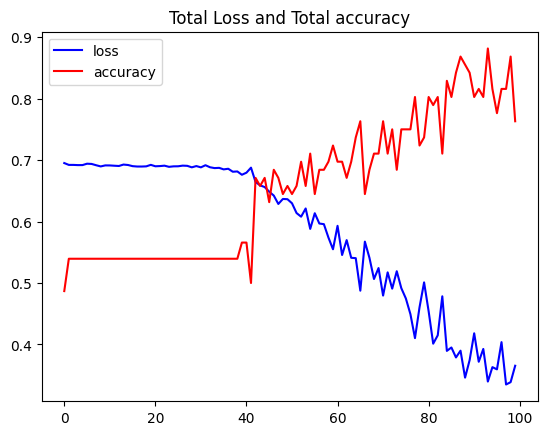

In [ ]:
plot_metric(convlstm_model_training_history, 'loss', 'accuracy', 'Total Loss and Total accuracy')

In [ ]:
y_pred = np.argmax(convlstm_model.predict(features),axis=1)
y_true  = np.argmax(one_hot_encoded_labels,axis=1)

3/3 [==============================] - 1s 67ms/step


In [ ]:
y_pred,y_true

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
        1, 1, 1, 1, 1, 1, 1, 1, 1, 1]))

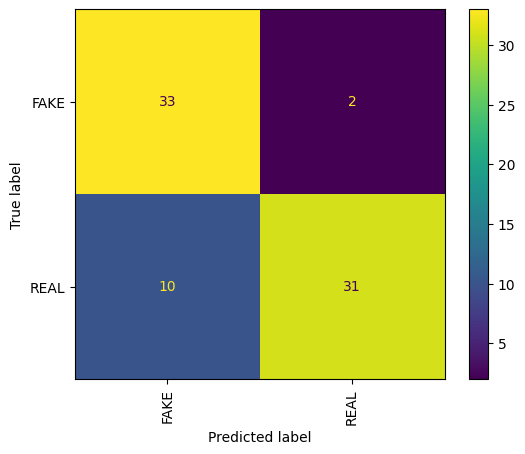

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay,confusion_matrix,f1_score,precision_score,recall_score,classification_report
ConfusionMatrixDisplay.from_predictions(y_true, y_pred,display_labels=CLASSES_LIST,xticks_rotation='vertical')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred,target_names=CLASSES_LIST))

              precision    recall  f1-score   support

        FAKE       0.77      0.94      0.85        35
        REAL       0.94      0.76      0.84        41

    accuracy                           0.84        76
   macro avg       0.85      0.85      0.84        76
weighted avg       0.86      0.84      0.84        76



**Prediction**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import cv2
import math
import random
import numpy as np
import datetime as dt
import tensorflow as tf
from collections import deque
import matplotlib.pyplot as plt

from moviepy.editor import *
%matplotlib inline

from sklearn.model_selection import train_test_split

seed_constant = 27
np.random.seed(seed_constant)
random.seed(seed_constant)
tf.random.set_seed(seed_constant)

In [ ]:
convlstm_model = tf.keras.models.load_model('/content/drive/MyDrive/projects/insta-reel/vid_model_checkpoint.keras')

In [ ]:
# Specify the height and width to which each video frame will be resized in our dataset.
IMAGE_HEIGHT , IMAGE_WIDTH = 64, 64

# Specify the number of frames of a video that will be fed to the model as one sequence.
SEQUENCE_LENGTH = 20

# Specify the list containing the names of the classes used for training. Feel free to choose any set of classes.
CLASSES_LIST = ['explicit', 'normal']

In [ ]:
def frames_extraction(video_path):
    '''
    This function will extract the required frames from a video after resizing and normalizing them.
    Args:
        video_path: The path of the video in the disk, whose frames are to be extracted.
    Returns:
        frames_list: A list containing the resized and normalized frames of the video.
    '''

    # Declare a list to store video frames.
    frames_list = []

    # Read the Video File using the VideoCapture object.
    video_reader = cv2.VideoCapture(video_path)

    # Get the total number of frames in the video.
    video_frames_count = int(video_reader.get(cv2.CAP_PROP_FRAME_COUNT))

    # Calculate the the interval after which frames will be added to the list.
    skip_frames_window = max(int(video_frames_count/SEQUENCE_LENGTH), 1)

    # Iterate through the Video Frames.
    for frame_counter in range(SEQUENCE_LENGTH):

        # Set the current frame position of the video.
        video_reader.set(cv2.CAP_PROP_POS_FRAMES, frame_counter * skip_frames_window)

        # Reading the frame from the video.
        success, frame = video_reader.read()

        # Check if Video frame is not successfully read then break the loop
        if not success:
            break

        # Resize the Frame to fixed height and width.
        resized_frame = cv2.resize(frame, (IMAGE_HEIGHT, IMAGE_WIDTH))

        # Normalize the resized frame by dividing it with 255 so that each pixel value then lies between 0 and 1
        normalized_frame = resized_frame / 255

        # Append the normalized frame into the frames list
        frames_list.append(normalized_frame)

    # Release the VideoCapture object.
    video_reader.release()

    # Return the frames list.
    return frames_list

In [ ]:
CLASSES_LIST

['explicit', 'normal']

In [ ]:
!cp -r "/content/drive/MyDrive/projects/insta-reel/sample_vid_data" "/content/sample_vid_data"

In [ ]:
def vid_class_pred(path,class_list):
    arr = np.array(frames_extraction(path))
    arr = np.expand_dims(arr, axis=0)
    model_pred = convlstm_model.predict(arr).ravel()
    pred_prob = max(model_pred)
    pred_class = class_list[np.argmax(model_pred)]
    return pred_class,pred_prob

In [ ]:
from IPython.display import HTML
from base64 import b64encode

vid_path = '/content/sample_vid_data/explicit/SaveInsta.App - 3250533429859118237.mp4'

mp4 = open(vid_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pred,prob = vid_class_pred(vid_path,CLASSES_LIST)
pred,prob

1/1 [==============================] - 4s 4s/step


('explicit', 0.9980854)

In [ ]:
vid_path = '/content/sample_vid_data/normal/SaveInsta.App - 3245273005947652816.mp4'
mp4 = open(vid_path,'rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=400 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pred,prob = vid_class_pred(vid_path,CLASSES_LIST)
pred,prob

1/1 [==============================] - 2s 2s/step


('normal', 0.8834512)